In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# import open3d as o3
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd
import cv2
import math
import gc

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from keras.layers import Input, Conv3D, BatchNormalization, MaxPool3D, Activation, Dropout, Dense, Flatten, MaxPooling3D, concatenate
import keras.backend as K
from keras.optimizers import SGD, Adam, Adadelta, Adamax, Nadam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
def label_raw_ds(data1, data2, data3, label=[0, 1, 2], delete_data=True, suffle=True, seed=0):
    len1, len2, len3 = data1.shape[0], data2.shape[0], data3.shape[0]
    assert data1.shape[1] == data2.shape[1] == data3.shape[1]
    mSize = int(np.power(data1.shape[1] / 3, 1/3))
    
    # print("mSize:" +  str(mSize) )

    data = np.concatenate([data1[:, :-3], 
                           data2[:, :-3], 
                           data3[:, :-3]], axis=0)
    
    print(data.shape)
    # seperate rotate label
    y_rotate = np.concatenate([data1[:, -3:], 
                               data2[:, -3:], 
                               data3[:, -3:]], axis=0)
        
    print(y_rotate.shape)
    # label the category
    y_category = np.zeros((data.shape[0], 1))
    
    y_category[:len1] = label[0]
    y_category[len1:len1 + len2] = label[1]
    y_category[-len3:] = label[2]

    print(y_category.shape)

    if delete_data ==True:
        del data1
        del data2
        del data3
        gc.collect()
    
    x_data = data.reshape(data.shape[0], mSize, mSize, mSize, 3)
    print(x_data.shape)
    if suffle:
        np.random.seed(seed)
        idx = np.arange(x_data.shape[0])
        np.random.shuffle(idx)
        
        x_data = x_data[idx]
        y_category = y_category[idx]
        y_rotate = y_rotate[idx]
                      
    return x_data, y_category, y_rotate

In [4]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'datasets',
 'data_generator',
 'data_generator_with_rotation.ipynb',
 'downsample.ipynb',
 'Feature_data_generator.ipynb',
 'Generate_3dCAD.ipynb',
 'gen_partial_pcd.ipynb',
 'KDTree.ipynb',
 'partial_registration_AOV_generator.ipynb',
 'projection_generator.ipynb',
 'recognition_data_generator.ipynb',
 'registration_data_generator.ipynb',
 'STL2PCD.ipynb',
 'Team_A_recognition_data_generator.ipynb']

In [5]:
data_path = "datasets/registration/"

## Create Train datasets

In [6]:
Armadill_raw  = np.loadtxt( data_path + "train_data/armadillo/feature_X+-3Y+-3Z+-3_50k.txt", max_rows=20000)
Bunny_raw    = np.loadtxt( data_path + "train_data/bunny/feature_X+-3Y+-3Z+-3_50k.txt", max_rows=20000)
Horse_raw    = np.loadtxt( data_path + "train_data/horse/feature_X+-3Y+-3Z+-3_50k.txt", max_rows=20000)

## Armadillo

In [7]:
Armadill_raw[0:1, :-3], Armadill_raw[0:1, -3:]

(array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[-0.030856,  0.048779,  0.047317]]))

In [8]:
np.max(Armadill_raw[:, -3:]), np.min(Armadill_raw[:, -3:]), np.mean(Armadill_raw[:, -3:])

(0.052359, -0.052358, -0.00013964948333333336)

In [9]:
np.max(Armadill_raw[:, :-3]), np.min(Armadill_raw[:, :-3]), np.mean(Armadill_raw[:, :-3])

(123.65230377, 0.0, 6.589227825274565)

## Bunny

In [10]:
Bunny_raw[0:1, :-3], Bunny_raw[0:1, -3:]

(array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.052306, -0.043614, -0.012358]]))

In [11]:
np.max(Bunny_raw[:, -3:]), np.min(Bunny_raw[:, -3:]), np.mean(Bunny_raw[:, -3:])

(0.052357, -0.052359, 0.00020008536666666664)

In [12]:
np.max(Bunny_raw[:, :-3]), np.min(Bunny_raw[:, :-3]), np.mean(Bunny_raw[:, :-3])

(157.865878353, 0.0, 9.430100353525976)

## Horse

In [13]:
Horse_raw[0:1, :-3], Horse_raw[0:1, -3:]

(array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.032958,  0.042494, -0.039062]]))

In [14]:
np.max(Horse_raw[:, -3:]), np.min(Horse_raw[:, -3:]), np.mean(Horse_raw[:, -3:])

(0.052357, -0.052359, -0.0001287826166666667)

In [15]:
np.max(Horse_raw[:, :-3]), np.min(Horse_raw[:, :-3]), np.mean(Horse_raw[:, :-3])

(159.203745625, 0.0, 6.891855829632239)

In [16]:
Armadill_raw.shape, Bunny_raw.shape, Horse_raw.shape

((20000, 5187), (20000, 5187), (20000, 5187))

In [17]:
x_train, y_train_c, y_train_r = label_raw_ds(Armadill_raw, Bunny_raw , Horse_raw)

(60000, 5184)
(60000, 3)
(60000, 1)
(60000, 12, 12, 12, 3)


In [18]:
x_train.shape, y_train_c.shape, y_train_r.shape

((60000, 12, 12, 12, 3), (60000, 1), (60000, 3))

In [19]:
y_train_c[:6]

array([[0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [1.]])

## Creating test datasets

In [20]:
Armadill_raw  = np.loadtxt( data_path + "dev_data/armadillo/feature_X+-3Y+-3Z+-3_1k_test.txt")
Bunny_raw    = np.loadtxt( data_path + "dev_data/bunny/feature_X+-3Y+-3Z+-3_1k_test.txt")
Horse_raw    = np.loadtxt( data_path + "dev_data/horse/feature_X+-3Y+-3Z+-3_1k_test.txt")

In [21]:
Armadill_raw[0:1, :-3], Armadill_raw[0:1, -3:]

(array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.028149,  0.038829, -0.002334]]))

In [22]:
np.max(Armadill_raw[:, -3:]), np.min(Armadill_raw[:, -3:]), np.mean(Armadill_raw[:, -3:])

(0.052295, -0.052344, -0.000687302)

In [23]:
np.max(Armadill_raw[:, :-3]), np.min(Armadill_raw[:, :-3]), np.mean(Armadill_raw[:, :-3])

(123.655950405, 0.0, 6.593216236030639)

In [24]:
X = Horse_raw[50, :-3].reshape(-1, 3)[:, 0]
Y = Horse_raw[50, :-3].reshape(-1, 3)[:, 1]
Z = Horse_raw[50, :-3].reshape(-1, 3)[:, 2]

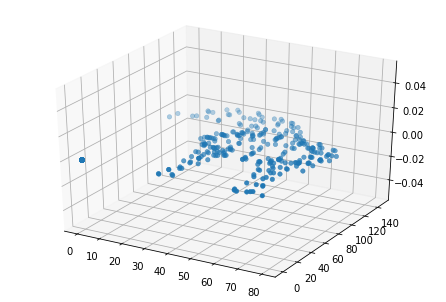

In [25]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X, Y, Z,  cmap='viridis', linewidth=0.5)

In [26]:
Bunny_raw[0:1, :-3], Bunny_raw[0:1, -3:]

(array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[-0.041411,  0.030745, -0.024801]]))

In [27]:
np.max(Bunny_raw[:, -3:]), np.min(Bunny_raw[:, -3:]), np.mean(Bunny_raw[:, -3:])

(0.052267, -0.05231, -0.00032932533333333326)

In [28]:
np.max(Bunny_raw[:, :-3]), np.min(Bunny_raw[:, :-3]), np.mean(Bunny_raw[:, :-3])

(157.831637459, 0.0, 9.40613572747408)

In [30]:
Horse_raw[0:1, :-3], Horse_raw[0:1, -3:]

(array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.025943, -0.016036,  0.020465]]))

In [29]:
np.max(Horse_raw[:, -3:]), np.min(Horse_raw[:, -3:]), np.mean(Horse_raw[:, -3:])

(0.052162, -0.052359, 0.000572708)

In [31]:
np.max(Horse_raw[:, :-3]), np.min(Horse_raw[:, :-3]), np.mean(Horse_raw[:, :-3])

(158.470381962, 0.0, 6.88300622269283)

In [32]:
x_test, y_test_c, y_test_r = label_raw_ds(Armadill_raw, Bunny_raw , Horse_raw)

(3000, 5184)
(3000, 3)
(3000, 1)
(3000, 12, 12, 12, 3)


In [33]:
x_test.shape, y_test_c.shape, y_test_r.shape

((3000, 12, 12, 12, 3), (3000, 1), (3000, 3))

In [34]:
y_test_c[:6]

array([[0.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.]])

In [35]:
label = ['Armadillo', 'Bunny', 'Horse']

In [36]:
if not os.path.exists('data_generator/datasets/recognition/npz'):
    os.makedirs('data_generator/datasets/recognition/npz')

In [37]:
np.savez('data_generator/datasets/recognition/npz/dataset.npz', x_train=x_train, y_train_c=y_train_c, y_train_r=y_train_r,
                                             x_test=x_test,   y_test_c=y_test_c,   y_test_r=y_test_r,                                             
                                             scale=np.max(x_train).tolist(), label=label)